# Match Trigger and Event Catalog

## Import Libraries

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy.signal.trigger import coincidence_trigger
from obspy import UTCDateTime
from numpy import sort, argmin, array
from pandas import DataFrame, value_counts, merge, read_pickle

from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.catalog_to_dataframe import __catalog_to_dataframe

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
config = {}

## old
# config['time_period'] = "20221001_20230615"

## new
config['time_period'] = "20221001_20230930"
# config['time_period'] = "20221001_20231001"

config['BSPF_lon'] = array([-116.455439])
config['BSPF_lat'] = array([33.610643])

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['catalog_filename'] = f"BSPF_catalog_{config['time_period']}_all.xml"

config['output_filename'] = f"BSPF_catalog_{config['time_period']}_triggered.xml"

config['client'] = Client("IRIS")

In [4]:
!ls /import/kilauea-data/BSPF/data/catalogs/

BSPF_catalog_20221001_20230930_all.pkl
BSPF_catalog_20221001_20230930_all.xml
BSPF_catalog_20221001_20230930_triggered.pkl
BSPF_catalog_20221001_20230930_triggered.xml
BSPF_catalog_20221001_20231001_all.pkl
BSPF_catalog_20221001_20231001_all.xml
BSPF_catalog_20221001_20231001_triggered.pkl
BSPF_catalog_20221001_20231001_triggered.xml
gcmt_solutions_20221001_20230930.xml
gcmt_solutions_20221001_20231001.xml
gmt_usgs_m3_m4.xml
good_events_20221001_20230930.pkl
good_events_20221001_20231001.pkl
OLD
tmp
triggered_2022-10-01_2023-09-30.log
triggered_2022-10-01_2023-09-30.pkl
triggered_2022-10-01_2023-10-01.pkl


## Load Catalog

In [5]:
## read catalog
cat = obs.read_events(config['path_to_catalogs']+config['catalog_filename'])
cat.events.sort(key=lambda event: event.origins[0].time)

## Load Triggered Events

In [6]:
def __read_pickle(config, path, filename):

    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)

    return triggerfile

In [7]:
trigger_events = __read_pickle(config, config['path_to_catalogs'], "triggered_2022-10-01_2023-09-30.pkl")

## Define reference time and separate for coincidence values

In [8]:
times, cosum, times_rel, duration = [], [], [], []
ref_time = obs.UTCDateTime("2022-10-01")

for trig in trigger_events:
    times.append(trig['time'])
    cosum.append(trig['coincidence_sum'])
    times_rel.append((trig['time']-ref_time)/86400)
    duration.append(round(trig['duration'], 2))

trigger_times = sort(times)

coinc4 = [ev for ev in trigger_events if ev['coincidence_sum'] == 4]
coinc5 = [ev for ev in trigger_events if ev['coincidence_sum'] == 5]
coinc6 = [ev for ev in trigger_events if ev['coincidence_sum'] == 6]

## Create dataframe & remove duplicates

In [9]:
df_trig = DataFrame()
df_trig['coincidence_sum'] = cosum
df_trig['trig_times_relative'] = times_rel
# df_trig['trigger_time'] = trigger_times
df_trig['trigger_time'] = trigger_times.astype(str)
df_trig['trigger_duration'] = duration

## remove duplicates of trigger time
df_trig = df_trig.drop_duplicates(["trigger_time"], keep="first").reset_index()

## remove trigger times before reference time
df_trig = df_trig[df_trig.trig_times_relative > 0]

trigger_times_unique = df_trig.trigger_time

print(f" removing duplicates")
print(f" before:  {len(trigger_times)}")
print(f" after:   {len(df_trig.trigger_time)}")

 removing duplicates
 before:  1487
 after:   888


In [10]:
coinc0 = df_trig[df_trig.coincidence_sum >= 0]
coinc4 = df_trig[df_trig.coincidence_sum == 4]
coinc5 = df_trig[df_trig.coincidence_sum == 5]
coinc6 = df_trig[df_trig.coincidence_sum == 6]

In [11]:
print(f" total events:      {len(cat)}")
print(f" triggered events:  {len(trigger_events)}")
print(f" triggered events no duplicates:  {len(df_trig.trigger_time)}")

print(f" CoInc. = 4:        {len(coinc4)} ({round(len(coinc4)/len(coinc0)*100, 1)} %)")
print(f" CoInc. = 5:        {len(coinc5)} ({round(len(coinc5)/len(coinc0)*100, 1)} %)")
print(f" CoInc. = 6:        {len(coinc6)} ({round(len(coinc6)/len(coinc0)*100, 1)} %)")

 total events:      10820
 triggered events:  1487
 triggered events no duplicates:  888
 CoInc. = 4:        327 (36.8 %)
 CoInc. = 5:        154 (17.3 %)
 CoInc. = 6:        407 (45.8 %)


## Match events of triggered catalog with event catalog

In [12]:
def __expected_arrival_times(catalog, sta_lat, sta_lon):

    from obspy.geodetics import locations2degrees
    from obspy.taup import TauPyModel

    model = TauPyModel(model="ak135") ## "ak135"

    expected_times, expected_paths = [], []
    for jj, ev in enumerate(catalog):
        if jj == 300:
            break

        ev_lat = ev.origins[0].latitude
        ev_lon = ev.origins[0].longitude
        ev_dep = ev.origins[0].depth / 1000
        ev_time = ev.origins[0].time

        dist_deg = locations2degrees(sta_lat, sta_lon, ev_lat, ev_lon)

        try:
            arrivals = model.get_travel_times(source_depth_in_km=ev_dep,
                                              distance_in_degree=dist_deg,
                                              phase_list=["P","S","pP","sS"]
                                             )
            print(arrivals)
            expected_times.append(ev_time + arrivals[0].time)
        except:
            print(f" -> failed to compute arrival times")

        try:
            paths = model.get_ray_paths(source_depth_in_km=ev_dep,
                                        distance_in_degree=dist_deg,
                                        phase_list=["P","S","pP","sS"]
                                        )
            expected_paths.append(paths)

        except:
            print(f" -> failed to compute arrival paths")

    return expected_times, expected_paths

In [13]:
# expected_times, expected_paths = __expected_arrival_times(cat[:20], config['BSPF_lat'], config['BSPF_lon'])
# expected_times, expected_paths

# for path in expected_paths:
#     try:
#         ax = path.plot_rays(plot_type="cartesian")
#     except:
#         print("no")

### Match triggers with event catalog based on travel time estimates

In [14]:
def __find_matches(catalog, sta_lat, sta_lon, trig_times, max_time_offset):

    from obspy.geodetics import locations2degrees
    from obspy.taup import TauPyModel
    from obspy import UTCDateTime, Catalog
    from tqdm.notebook import tqdm

    ## model for arrival times
    model = TauPyModel(model="ak135") ## "ak135", "iasp91", "prem"

    ## counter for failed arrival computations
    fails = 0

    ## output dataframe
    df_out = DataFrame(columns=["id", "event_time", "arrival_time", "trigger_time", "arrivals_computed"])

    ## output catalog
    cat_out = Catalog()


    for jj, ev in enumerate(tqdm(catalog)):

#         if jj == 100:
#             break

        ## extract event data
        ev_lat = ev.origins[0].latitude
        ev_lon = ev.origins[0].longitude
        ev_dep = ev.origins[0].depth / 1000
        ev_time = ev.origins[0].time

        ## compute distance between station to event in degrees
        dist_deg = locations2degrees(sta_lat, sta_lon, ev_lat, ev_lon)

        # print(dist_deg[0], ev_dep)

        try:
            arrivals = model.get_travel_times(source_depth_in_km=ev_dep,
                                              distance_in_degree=dist_deg[0],
                                              # phase_list=["P","S","pP","sS","sP","pS"]
                                              phase_list=["P"]
                                             )
            # print(arrivals)
            expected_time = ev_time + arrivals[0].time
            arrivals_computed = 1

        except Exception as e:
            # print(e)
            fails += 1
            expected_time = ev_time
            arrivals_computed = 0


        for nn, trig in enumerate(trig_times):

            ## compute absolute temporal distance
            abs_diff = abs(expected_time - UTCDateTime(trig))

            # diff = expected_time - UTCDateTime(trig)

            ## if distance below threshold, trigger is considered match with catalog event
            if abs_diff < max_time_offset:
                df_out.loc[len(df_out)] = [jj, ev_time, expected_time, trig, arrivals_computed]
                cat_out += ev
            else:
                continue


    print(f" -> failed for {fails} of {len(catalog)} to compute arrival times..:")

    return df_out, cat_out

In [15]:
df_out, cat_select = __find_matches(cat, config['BSPF_lat'], config['BSPF_lon'], trigger_times_unique, max_time_offset=10)

  0%|          | 0/10820 [00:00<?, ?it/s]

 -> failed for 6230 of 10820 to compute arrival times..:


In [34]:
df_all = merge(df_trig, df_out, on=['trigger_time'])
df_all

,index,coincidence_sum,trig_times_relative,trigger_time,trigger_duration,id,event_time,arrival_time,arrivals_computed
0,6,6.0,0.159144,2022-10-01T05:36:10.344538Z,52.14,3,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,0
1,7,6.0,0.200810,2022-10-01T05:36:14.169539Z,36.99,3,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,0
2,30,6.0,0.867477,2022-10-01T21:26:51.594539Z,49.67,21,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,0
3,31,5.0,0.893654,2022-10-01T21:26:51.694538Z,9.92,21,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,0
4,39,6.0,1.142584,2022-10-02T03:25:19.219539Z,5.75,32,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,0
...,...,...,...,...,...,...,...,...,...
518,1472,4.0,355.082244,2023-09-21T01:58:25.860000Z,4.77,10598,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,0
519,1474,4.0,355.082244,2023-09-21T21:26:20.975000Z,4.77,10619,2023-09-21T21:26:10.420000Z,2023-09-21T21:26:22.103722Z,1
520,1476,4.0,356.408666,2023-09-22T09:48:28.755000Z,11.99,10628,2023-09-22T09:48:22.760000Z,2023-09-22T09:48:22.760000Z,0
521,1478,5.0,361.570266,2023-09-27T13:41:10.945000Z,5.86,10762,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,0


In [35]:
df_all[df_all.arrivals_computed == 1].size

990

## Reject manually selected events of false positive triggers

In [36]:
## list of events to reject (manually)
no_event = ["2022-10-05 15:39:13.690",
            "2022-10-05 15:42:03.610",
            "2022-10-05 18:35:16.860",
            "2022-10-10 05:48:52.890",
            "2022-10-12 19:12:14.670",
            "2022-10-12 23:08:11.410",
            "2022-10-12 23:58:00.800",
            "2022-10-14 03:13:56.380",
            "2022-10-16 08:42:24.970",
            "2022-10-26 08:27:09.860",
            "2022-10-28 12:47:26.910",
            "2022-11-03 05:53:34.230",
            "2022-11-09 00:46:57.550",
            "2022-11-10 16:53:29.940",
            "2022-11-25 10:45:36.390",
            "2022-12-06 21:56:31.330",
            "2022-12-09 06:03:03.220",
            "2022-12-15 13:55:13.460",
            "2022-12-17 18:02:34.910",
            "2022-12-19 15:41:22.380",
            "2022-12-19 15:41:26.020",
            "2023-01-05 09:59:04.210",
            "2023-01-07 12:32:45.250",
            "2023-01-16 00:00:36.100",
            "2023-01-29 23:50:47.770",
            "2023-02-05 23:38:46.670",
            "2023-02-22 05:09:39.970",
            "2023-03-09 11:49:06.640",
            "2023-03-17 07:12:56.970",
            "2023-03-24 13:59:00.160",
            "2023-03-29 19:23:29.470",
            "2023-03-29 19:23:27.460",
            "2023-04-30 07:26:56.390",
            "2023-04-06 02:42:00.600",
            "2023-04-13 23:57:53.950",
            "2023-04-17 15:27:56.450",
            "2023-05-01 02:52:56.160",
            "2023-06-02 20:19:46.740",
            "2023-06-05 07:39:16.650",
            "2023-09-11 23:57:56.280", ## to small for the distance
            "2022-10-26 08:14:33.950", ## dubplicate trigger time
            "2022-11-30 14:05:03.530", ## dubplicate trigger time
            "2022-12-05 10:55:03.520", ## dubplicate trigger time
            "2023-02-01 09:19:10.710", ## dubplicate trigger time
            "2023-03-26 07:47:55.340", ## dubplicate trigger time
            "2023-03-26 07:47:59.500", ## dubplicate trigger time
            "2023-04-10 14:50:54.400", ## dubplicate trigger time
            "2023-04-30 07:27:20.170", ## dubplicate trigger time
            "2023-05-09 03:01:09.100", ## dubplicate trigger time
            "2023-06-05 17:22:15.270", ## dubplicate trigger time
            "2023-06-28 01:45:06.060", ## dubplicate trigger time
            "2023-07-10 20:53:23.380", ## dubplicate trigger time
            "2023-07-12 02:29:00.340", ## dubplicate trigger time
            "2023-07-24 18:18:36.100", ## dubplicate trigger time
            "2023-03-07 18:36:06.770", ## dubplicate trigger time
           ]

## Remove manually selected events from catalog and create new catalog

In [37]:
no_event_utc = list(map(UTCDateTime, no_event))

n_before = len(df_all)

## remove defined events from data frame
df_all = df_all[df_all['event_time'].apply(lambda x: x not in no_event_utc)].reset_index()

## remove defined events from catalog
new_cat = obs.Catalog()
for tmp_ev in cat_select:
    if tmp_ev.origins[0].time not in no_event_utc:
        new_cat += tmp_ev

cat_select = new_cat


print(f" before:  {n_before} \n after:   {len(df_all)} \n manuall list: {len(no_event_utc)}  \n rejected: {n_before-len(df_all)}")

 before:  523 
 after:   465 
 manuall list: 55  
 rejected: 58


array([<Axes: title={'center': 'dates'}>], dtype=object)

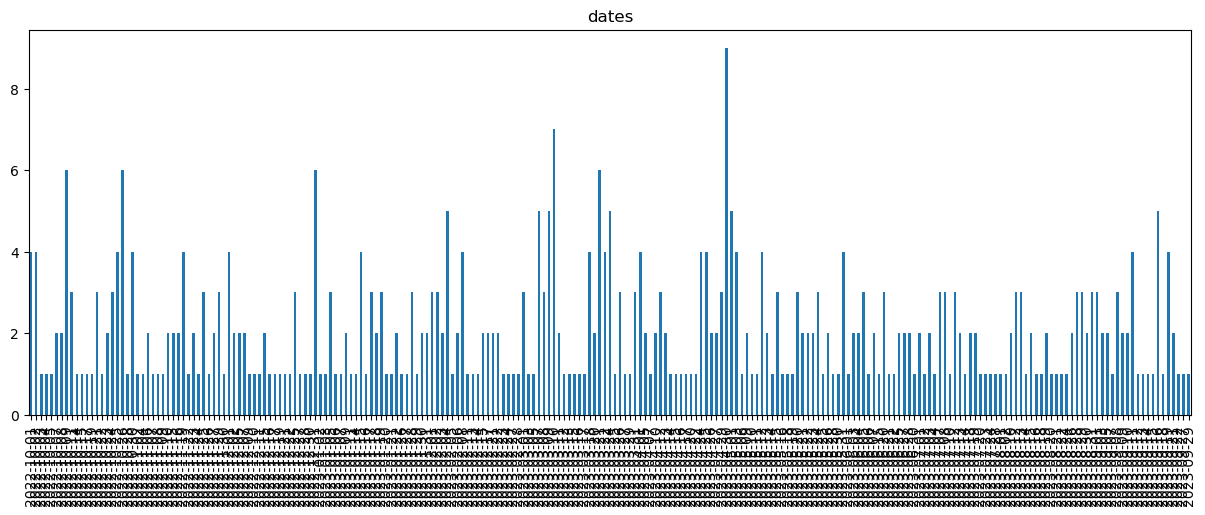

In [38]:
dates = [str(cat_select[ii].origins[0].time.date) for ii in range(len(cat_select))]

df = DataFrame()
df['dates'] = dates
df = df.sort_values(by="dates")

df2 = df.apply(value_counts)
df2.sort_index(inplace=True)

df2.dates.plot(kind='bar', subplots=True, figsize=(15, 5))

## Create Catalog of triggered events that were matched with catalog events

In [39]:
cat_select.write(config['path_to_catalogs']+config['output_filename'], format="QUAKEML")
print(f" -> storing: {config['path_to_catalogs']}{config['output_filename']} ... ")

 -> storing: /import/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20230930_triggered.xml ... 


In [40]:
cata_df = __catalog_to_dataframe(cat_select)


## create a data frame for the triggered catalog
cata_df = cata_df.rename_axis('origin').reset_index()
cata_df['seconds'] = [abs(UTCDateTime(str(tt))-UTCDateTime("2022-10-01")) for tt in cata_df.origin]
cata_df['trigger_time'] = df_all.trigger_time
cata_df['arrival_time'] = df_all.arrival_time
cata_df['event_time'] = df_all.event_time
cata_df['cosum'] = df_all.coincidence_sum


## add information on epicentral distance and backazimuths
cata_df = __add_distances_and_backazimuth(config['BSPF_lat'], config['BSPF_lon'], cata_df)

## remove events where magnitude is smaller than 1 and distance is larger than 15km
cata_df.drop(cata_df[(cata_df.magnitude < 1) & (cata_df.distances_km > 15)].index, inplace=True)
cata_df.reset_index(drop=True)

## remove duplicated trigger times and event times
# cata_df = cata_df.drop_duplicates("trigger_time", keep="first").reset_index(drop=True)
cata_df = cata_df.drop_duplicates("event_time").reset_index(drop=True)


## write data to output file
cata_df.to_pickle(config['path_to_catalogs']+config['output_filename'].replace(".xml",".pkl"))
print(f" -> storing: {config['path_to_catalogs']}{config['output_filename'].replace('.xml','.pkl')}...")

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,6.0,199.712618,14.252022
1,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:14.169539Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,6.0,199.712618,14.252022
2,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.594539Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535
3,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.694538Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,5.0,328.065144,48.053535
4,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.219539Z,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966
...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,2023-09-21 01:58:24.210,33.545833,-116.455000,4870.0,0.68,ml,30679104.21,2023-09-21T01:58:25.860000Z,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,4.0,179.675029,7.188470
449,2023-09-21 21:26:10.420,34.031000,-116.912500,14140.0,2.26,ml,30749170.42,2023-09-21T21:26:20.975000Z,2023-09-21T21:26:22.103722Z,2023-09-21T21:26:10.420000Z,4.0,317.902461,62.963464
450,2023-09-22 09:48:22.760,33.270167,-116.781000,11290.0,1.72,ml,30793702.76,2023-09-22T09:48:28.755000Z,2023-09-22T09:48:22.760000Z,2023-09-22T09:48:22.760000Z,4.0,218.807178,48.399101
451,2023-09-27 13:41:07.510,33.496500,-116.556833,13430.0,1.18,ml,31239667.51,2023-09-27T13:41:10.945000Z,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,5.0,216.668239,15.777807


 -> storing: /import/kilauea-data/BSPF/data/catalogs/BSPF_catalog_20221001_20230930_triggered.pkl...


In [41]:
cata_df

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,6.0,199.712618,14.252022
1,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.594539Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535
2,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.219539Z,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966
3,2022-10-02 15:51:37.180,33.480167,-116.398000,8240.0,1.68,ml,143497.18,2022-10-02T15:51:39.919539Z,2022-10-02T15:51:37.180000Z,2022-10-02T15:51:37.180000Z,6.0,159.749086,15.423592
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.319539Z,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2023-09-21 01:58:24.210,33.545833,-116.455000,4870.0,0.68,ml,30679104.21,2023-09-21T01:58:25.860000Z,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,4.0,179.675029,7.188470
402,2023-09-21 21:26:10.420,34.031000,-116.912500,14140.0,2.26,ml,30749170.42,2023-09-21T21:26:20.975000Z,2023-09-21T21:26:22.103722Z,2023-09-21T21:26:10.420000Z,4.0,317.902461,62.963464
403,2023-09-22 09:48:22.760,33.270167,-116.781000,11290.0,1.72,ml,30793702.76,2023-09-22T09:48:28.755000Z,2023-09-22T09:48:22.760000Z,2023-09-22T09:48:22.760000Z,4.0,218.807178,48.399101
404,2023-09-27 13:41:07.510,33.496500,-116.556833,13430.0,1.18,ml,31239667.51,2023-09-27T13:41:10.945000Z,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,5.0,216.668239,15.777807


In [42]:
print("number of events: ", len(cata_df.origin))
print("max. magnitude: ", max(cata_df.magnitude))
print("min. magnitude: ", min(cata_df.magnitude))

print("max. distance: ", round(max(cata_df.distances_km),2), "km")
print("min. distance: ", round(min(cata_df.distances_km),2), "km")

number of events:  406
max. magnitude:  4.33
min. magnitude:  0.6
max. distance:  152.0 km
min. distance:  7.19 km


## Check for small magnitudes (if distances are reasonable)

In [43]:
cata_df

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,6.0,199.712618,14.252022
1,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.594539Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535
2,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.219539Z,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966
3,2022-10-02 15:51:37.180,33.480167,-116.398000,8240.0,1.68,ml,143497.18,2022-10-02T15:51:39.919539Z,2022-10-02T15:51:37.180000Z,2022-10-02T15:51:37.180000Z,6.0,159.749086,15.423592
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.319539Z,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2023-09-21 01:58:24.210,33.545833,-116.455000,4870.0,0.68,ml,30679104.21,2023-09-21T01:58:25.860000Z,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,4.0,179.675029,7.188470
402,2023-09-21 21:26:10.420,34.031000,-116.912500,14140.0,2.26,ml,30749170.42,2023-09-21T21:26:20.975000Z,2023-09-21T21:26:22.103722Z,2023-09-21T21:26:10.420000Z,4.0,317.902461,62.963464
403,2023-09-22 09:48:22.760,33.270167,-116.781000,11290.0,1.72,ml,30793702.76,2023-09-22T09:48:28.755000Z,2023-09-22T09:48:22.760000Z,2023-09-22T09:48:22.760000Z,4.0,218.807178,48.399101
404,2023-09-27 13:41:07.510,33.496500,-116.556833,13430.0,1.18,ml,31239667.51,2023-09-27T13:41:10.945000Z,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,5.0,216.668239,15.777807


In [44]:
print(len(cata_df[cata_df.magnitude < 1]), cata_df.magnitude.min())
cata_df[cata_df.magnitude < 1]


26 0.6


,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.319539Z,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415
11,2022-10-09 08:33:00.550,33.553500,-116.406167,8330.0,0.91,ml,721980.55,2022-10-09T08:33:01.044538Z,2022-10-09T08:33:00.550000Z,2022-10-09T08:33:00.550000Z,4.0,144.168138,7.816232
13,2022-10-09 17:51:16.290,33.488000,-116.501833,10350.0,0.88,ml,755476.29,2022-10-09T17:51:19.494538Z,2022-10-09T17:51:16.290000Z,2022-10-09T17:51:16.290000Z,6.0,197.588132,14.268919
14,2022-10-09 19:55:28.380,33.493333,-116.475500,15760.0,0.86,ml,762928.38,2022-10-09T19:55:31.794538Z,2022-10-09T19:55:28.380000Z,2022-10-09T19:55:28.380000Z,4.0,188.153958,13.144024
16,2022-10-11 19:06:27.140,33.492333,-116.505833,3460.0,0.88,ml,932787.14,2022-10-11T19:06:29.594538Z,2022-10-11T19:06:27.140000Z,2022-10-11T19:06:27.140000Z,6.0,199.642497,13.931815
21,2022-10-21 05:15:45.520,33.489500,-116.497000,9580.0,0.75,ml,1746945.52,2022-10-21T05:15:48.494538Z,2022-10-21T05:15:45.520000Z,2022-10-21T05:15:45.520000Z,4.0,196.038584,13.979869
22,2022-10-21 05:28:17.380,33.491833,-116.500833,10800.0,0.60,ml,1747697.38,2022-10-21T05:28:20.444538Z,2022-10-21T05:28:17.380000Z,2022-10-21T05:28:17.380000Z,4.0,197.752504,13.835588
23,2022-10-21 08:53:10.210,33.513500,-116.502667,13120.0,0.87,ml,1759990.21,2022-10-21T08:53:13.069538Z,2022-10-21T08:53:10.210000Z,2022-10-21T08:53:10.210000Z,4.0,202.159994,11.632836
50,2022-11-15 16:02:41.970,33.573167,-116.595667,13450.0,0.87,ml,3945761.97,2022-11-15T16:02:45.219538Z,2022-11-15T16:02:41.970000Z,2022-11-15T16:02:41.970000Z,6.0,252.328490,13.664113
58,2022-11-24 15:53:28.730,33.495500,-116.500333,10300.0,0.81,ml,4722808.73,2022-11-24T15:53:31.694538Z,2022-11-24T15:53:28.730000Z,2022-11-24T15:53:28.730000Z,4.0,198.091880,13.434301


## Check for duplicated events

In [45]:
cata_df[cata_df.duplicated("event_time", keep=False)]
cata_df[cata_df.duplicated("trigger_time", keep=False)]

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km


,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km


In [46]:
## remove clearly visible outlier on 2023-04-30T07:26:56.390000Z
# cata_df[(cata_df.seconds > 86400*210) & (cata_df.seconds < 86400*215)]

# print(cat.filter("time > 2023-04-30T06:10","time < 2023-04-30T08:20", "magnitude > 2", inverse=False).__str__(print_all=True))

In [47]:
cata_df[cata_df.magnitude > 3]

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
5,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,230889.97,2022-10-03T16:08:19.094538Z,2022-10-03T16:08:09.970000Z,2022-10-03T16:08:09.970000Z,5.0,309.024563,55.472148
8,2022-10-07 22:45:05.470,33.041333,-116.354667,11790.0,3.47,mlr,600305.47,2022-10-07T22:45:15.194538Z,2022-10-07T22:45:17.491542Z,2022-10-07T22:45:05.470000Z,6.0,171.520189,63.835594
25,2022-10-23 09:24:58.150,33.480667,-116.426167,5790.0,3.27,ml,1934698.15,2022-10-23T09:24:58.344538Z,2022-10-23T09:24:58.150000Z,2022-10-23T09:24:58.150000Z,6.0,169.312421,14.670320
68,2022-12-01 15:28:29.660,32.836167,-116.040333,10460.0,3.82,mw,5326109.66,2022-12-01T15:28:44.094539Z,2022-12-01T15:28:46.445320Z,2022-12-01T15:28:29.660000Z,6.0,155.635141,94.209117
92,2022-12-31 11:41:09.460,34.355667,-116.921833,4730.0,3.47,mw,7904469.46,2022-12-31T11:41:24.869538Z,2022-12-31T11:41:26.535428Z,2022-12-31T11:41:09.460000Z,6.0,332.588181,93.201512
93,2022-12-31 12:12:26.650,33.397500,-116.393333,3880.0,4.14,mw,7906346.65,2022-12-31T12:12:27.844538Z,2022-12-31T12:12:26.650000Z,2022-12-31T12:12:26.650000Z,6.0,166.264929,24.334570
105,2023-01-09 19:42:56.460,33.396000,-116.396667,4890.0,3.18,ml,8710976.46,2023-01-09T19:42:59.119538Z,2023-01-09T19:42:56.460000Z,2023-01-09T19:42:56.460000Z,5.0,167.064154,24.425123
106,2023-01-11 18:59:20.030,33.699833,-116.761333,15820.0,3.23,ml,8881160.03,2023-01-11T18:59:24.544538Z,2023-01-11T18:59:20.030000Z,2023-01-11T18:59:20.030000Z,6.0,289.306150,30.048739
129,2023-02-01 09:05:02.320,33.886000,-116.257833,3190.0,3.11,ml,10659902.32,2023-02-01T09:05:07.669538Z,2023-02-01T09:05:02.320000Z,2023-02-01T09:05:02.320000Z,6.0,30.887144,35.609655
145,2023-02-13 10:09:46.070,32.985833,-115.925667,11070.0,3.24,ml,11700586.07,2023-02-13T10:10:10.319536Z,2023-02-13T10:10:01.392917Z,2023-02-13T10:09:46.070000Z,5.0,144.402363,85.068713


## Select good events manually

In [48]:
good_event = [
            "20221002_032516",
            "20221015_051734",
            "20221023_092458",
            "20221026_081433", ## double event
            "20221231_121226",
            "20230109_194256",
            "20230301_224903",
            "20230308_040732",
            "20230410_145054",
            "20230417_185236",
            "20230425_115547",
            "20230430_221115",
            "20230707_160229",
            "20230828_102734",
            "20230830_153205",
            "20230911_092015",
            "20230919_003513"
           ]

In [49]:
## get indices of good events
idx = []
for ge in good_event:
    for i, ev in zip(cata_df.index, cata_df.origin):
        ev_str = str(ev).split(".")[0].replace(" ", "_").replace("-","").replace(":","")
        if ge == ev_str:
            idx.append(i)

## extract good events as separate catalog
cata_good = cata_df[cata_df.index.isin(idx)].reset_index().rename(columns={"index":"event_number"})

## write data to output file
cata_good.to_pickle(config['path_to_catalogs']+f"good_events_{config['time_period']}.pkl")
print(f" -> storing: {config['path_to_catalogs']}good_events_{config['time_period']}.pkl ...")

 -> storing: /import/kilauea-data/BSPF/data/catalogs/good_events_20221001_20230930.pkl ...


In [50]:
cata_df[cata_df.distances_km > 100]

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km
89,2022-12-27 14:50:47.040,34.579500,-116.887333,5530.0,2.99,ml,7570247.04,2022-12-27T14:51:05.794538Z,2022-12-27T14:51:07.349559Z,2022-12-27T14:50:47.040000Z,5.0,339.773053,114.621642
226,2023-04-14 14:56:56.320,32.521500,-115.625500,15530.0,3.52,mlr,16901816.32,2023-04-14T14:57:18.115000Z,2023-04-14T14:57:19.750155Z,2023-04-14T14:56:56.320000Z,6.0,147.087703,143.516359
242,2023-04-29 12:07:03.500,32.711000,-115.544833,10430.0,4.09,mw,18187623.50,2023-04-29T12:07:23.040000Z,2023-04-29T12:07:25.921864Z,2023-04-29T12:07:03.500000Z,5.0,139.340930,131.036645
362,2023-08-29 08:05:33.310,33.001833,-117.917667,5980.0,3.60,mw,28713933.31,2023-08-29T08:05:56.620000Z,2023-08-29T08:05:58.889481Z,2023-08-29T08:05:33.310000Z,6.0,244.028238,151.995130
398,2023-09-19 09:54:27.540,34.112167,-117.470000,6800.0,3.06,ml,30534867.54,2023-09-19T09:54:45.275000Z,2023-09-19T09:54:46.857830Z,2023-09-19T09:54:27.540000Z,5.0,300.930422,109.124686
